# **Malaria Detection**


##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>

**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive


### <b>Loading libraries</b>


In [38]:
import zipfile
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

### <b>Let us load the data</b>


**Note:**

- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.


In [2]:
# Storing the path of the data file from the Google drive
path = "/home/iamtxena/sandbox/mit-ai/capstone/Malaria_Detection/data/cell_images.zip"

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, "r") as zip_ref:

    zip_ref.extractall()

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.


In [15]:
train_dir = "/home/iamtxena/sandbox/mit-ai/capstone/Malaria_Detection/data/cell_images/train"
test_dir = "/home/iamtxena/sandbox/mit-ai/capstone/Malaria_Detection/data/cell_images/test"

###<b> Check the shape of train and test images


In [11]:
# This section is intended to check the shape of train and test images to ensure they meet the requirements for input into our convolutional neural network.
def get_image_shape(image_path):
    with Image.open(image_path) as img:
        return img.size  # Returns (width, height)


def get_first_image_shape(directory):
    for sub_dir in os.listdir(directory):
        sub_dir_path = os.path.join(directory, sub_dir)
        if os.path.isdir(sub_dir_path):  # Ensure it's a directory
            for file in os.listdir(sub_dir_path):
                file_path = os.path.join(sub_dir_path, file)
                if os.path.isfile(file_path):  # Ensure it's a file
                    return get_image_shape(file_path)
    return None


# Get the shape of the first image in the train and test directories
train_image_shape = get_first_image_shape(train_dir)
test_image_shape = get_first_image_shape(test_dir)

print(f"Train image shape: {train_image_shape}")
print(f"Test image shape: {test_image_shape}")

Train image shape: (127, 142)
Test image shape: (142, 139)


In [12]:
def check_all_images_shape(directory):
    shapes = set()
    for sub_dir in os.listdir(directory):
        sub_dir_path = os.path.join(directory, sub_dir)
        if os.path.isdir(sub_dir_path):  # Ensure it's a directory
            for file in os.listdir(sub_dir_path):
                file_path = os.path.join(sub_dir_path, file)
                if os.path.isfile(file_path):  # Ensure it's a file
                    with Image.open(file_path) as img:
                        shapes.add(img.size)  # Add image size to the set
    return shapes


# Check shapes in train and test directories
train_shapes = check_all_images_shape(train_dir)
test_shapes = check_all_images_shape(test_dir)

# Print the unique shapes found in each directory
print(f"Unique shapes in train directory: {train_shapes}")
print(f"Unique shapes in test directory: {test_shapes}")

# Check if all images have the same shape
if len(train_shapes) == 1 and len(test_shapes) == 1 and list(train_shapes)[0] == list(test_shapes)[0]:
    print("All images in both train and test directories have the same shape.")
else:
    print("Not all images have the same shape.")

Unique shapes in train directory: {(166, 181), (124, 184), (130, 115), (139, 163), (199, 214), (205, 145), (97, 166), (163, 148), (121, 151), (196, 181), (94, 133), (154, 184), (193, 175), (157, 109), (127, 166), (187, 217), (190, 142), (109, 154), (127, 202), (148, 145), (160, 199), (142, 187), (181, 178), (145, 112), (238, 160), (103, 115), (160, 91), (118, 94), (178, 145), (136, 148), (142, 79), (100, 82), (151, 127), (130, 190), (169, 181), (175, 112), (133, 115), (226, 163), (91, 118), (106, 97), (166, 148), (226, 199), (124, 151), (130, 82), (88, 85), (139, 130), (97, 133), (157, 184), (163, 115), (121, 118), (172, 163), (196, 148), (94, 100), (154, 151), (172, 199), (112, 154), (94, 136), (127, 133), (187, 184), (112, 190), (145, 187), (109, 121), (127, 169), (148, 112), (145, 223), (184, 151), (142, 154), (181, 145), (142, 190), (103, 82), (175, 187), (115, 172), (136, 115), (208, 220), (151, 94), (58, 52), (130, 157), (169, 148), (133, 82), (205, 187), (130, 193), (91, 85), (2

###<b> Check the shape of train and test labels


In [17]:
def get_labels_from_directory(directory):
    labels = []
    categories = os.listdir(directory)
    category_to_label = {category: i for i, category in enumerate(categories)}

    for category in categories:
        category_path = os.path.join(directory, category)
        for image in os.listdir(category_path):
            labels.append(category_to_label[category])

    return labels, category_to_label


train_labels, train_category_to_label = get_labels_from_directory(train_dir)
test_labels, test_category_to_label = get_labels_from_directory(test_dir)

print(f"Shape of train labels: {len(train_labels):,}")
print(f"Shape of test labels: {len(test_labels):,}")

Shape of train labels: 24,958
Shape of test labels: 2,600


In [19]:
def resize_images_and_create_labels(directory, new_size=(64, 64)):
    """
    Resize images to a specified size and create labels.

    Parameters:
    - directory: The path to the directory containing subdirectories of images.
    - new_size: A tuple indicating the new size (width, height) to which the images will be resized.

    Returns:
    - A tuple of two lists: the first containing the resized images as NumPy arrays, and the second containing the labels.
    """
    images = []  # List to store the resized images
    labels = []  # List to store the labels
    categories = os.listdir(directory)  # Get the list of subdirectory names
    category_to_label = {category: i for i, category in enumerate(categories)}  # Map category names to numeric labels

    for category in categories:
        category_path = os.path.join(directory, category)  # Path to the subdirectory
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)  # Path to the image
            try:
                with Image.open(image_path) as img:
                    img_resized = img.resize(new_size)  # Resize the image
                    images.append(np.array(img_resized))  # Convert the image to a NumPy array and append to the list
                    labels.append(category_to_label[category])  # Append the corresponding label
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

    return images, labels


# Resize images and create labels for the training dataset
train_images, train_labels = resize_images_and_create_labels(train_dir)

# Resize images and create labels for the testing dataset
test_images, test_labels = resize_images_and_create_labels(test_dir)

# Convert the lists of images and labels to NumPy arrays for further processing
train_images_np = np.array(train_images)
train_labels_np = np.array(train_labels)
test_images_np = np.array(test_images)
test_labels_np = np.array(test_labels)

Training images shape: (24958, 64, 64, 3)
Training labels shape: (24958,)
Testing images shape: (2600, 64, 64, 3)
Testing labels shape: (2600,)


In [21]:
# Function to format each dimension of the shape with commas
def format_shape_with_commas(shape):
    return "(" + ", ".join(f"{dim:,}" for dim in shape) + ")"


# Print the shapes of the arrays with formatted dimensions
print(f"Training images shape: {format_shape_with_commas(train_images_np.shape)}")
print(f"Training labels shape: {format_shape_with_commas(train_labels_np.shape)}")
print(f"Testing images shape: {format_shape_with_commas(test_images_np.shape)}")
print(f"Testing labels shape: {format_shape_with_commas(test_labels_np.shape)}")

Training images shape: (24,958, 64, 64, 3)
Training labels shape: (24,958)
Testing images shape: (2,600, 64, 64, 3)
Testing labels shape: (2,600)


####<b> Observations and insights: **\_**


### <b>Check the minimum and maximum range of pixel values for train and test images


In [23]:
# Assuming train_images_np and test_images_np are already defined and contain the loaded images

# Find the minimum and maximum pixel values in the training images
train_min = np.min(train_images_np)
train_max = np.max(train_images_np)

# Find the minimum and maximum pixel values in the testing images
test_min = np.min(test_images_np)
test_max = np.max(test_images_np)

# Print the results with formatted numbers for better readability
print(f"Training data - Min pixel value: {train_min}, Max pixel value: {train_max}")
print(f"Testing data - Min pixel value: {test_min}, Max pixel value: {test_max}")

Training data - Min pixel value: 0, Max pixel value: 255
Testing data - Min pixel value: 0, Max pixel value: 255


####<b> Observations and insights: **\_**


###<b> Count the number of values in both uninfected and parasitized


In [26]:
# Assuming train_labels_np and test_labels_np are NumPy arrays containing the labels for training and testing datasets

# Count the number of 'uninfected' (0) and 'parasitized' (1) in the training dataset
train_uninfected_count = np.sum(train_labels_np == 0)
train_parasitized_count = np.sum(train_labels_np == 1)

# Count the number of 'uninfected' (0) and 'parasitized' (1) in the testing dataset
test_uninfected_count = np.sum(test_labels_np == 0)
test_parasitized_count = np.sum(test_labels_np == 1)

# Print the counts
print(f"Training dataset: Uninfected - {train_uninfected_count:,}, Parasitized - {train_parasitized_count:,}")
print(f"Testing dataset: Uninfected - {test_uninfected_count:,}, Parasitized - {test_parasitized_count:,}")

Training dataset: Uninfected - 12,376, Parasitized - 12,582
Testing dataset: Uninfected - 1,300, Parasitized - 1,300


In [27]:
import pandas as pd

# Assuming train_labels_np and test_labels_np are NumPy arrays containing the labels

# Convert the NumPy arrays to pandas Series
train_labels_series = pd.Series(train_labels_np)
test_labels_series = pd.Series(test_labels_np)

# Use value_counts() to count occurrences of each label in the training and testing datasets
train_label_counts = train_labels_series.value_counts()
test_label_counts = test_labels_series.value_counts()

# Print the counts
print("Training dataset label counts:")
print(train_label_counts)
print("\nTesting dataset label counts:")
print(test_label_counts)

Training dataset label counts:
1    12582
0    12376
Name: count, dtype: int64

Testing dataset label counts:
0    1300
1    1300
Name: count, dtype: int64


###<b>Normalize the images


In [28]:
# Normalize the training and testing images
train_images_np_normalized = train_images_np.astype("float32") / 255.0
test_images_np_normalized = test_images_np.astype("float32") / 255.0

# Optionally, you can verify the min and max values after normalization
print(f"Normalized training images - Min: {train_images_np_normalized.min()}, Max: {train_images_np_normalized.max()}")
print(f"Normalized testing images - Min: {test_images_np_normalized.min()}, Max: {test_images_np_normalized.max()}")

Normalized training images - Min: 0.0, Max: 1.0
Normalized testing images - Min: 0.0, Max: 1.0


####<b> Observations and insights: **\_**


###<b> Plot to check if the data is balanced


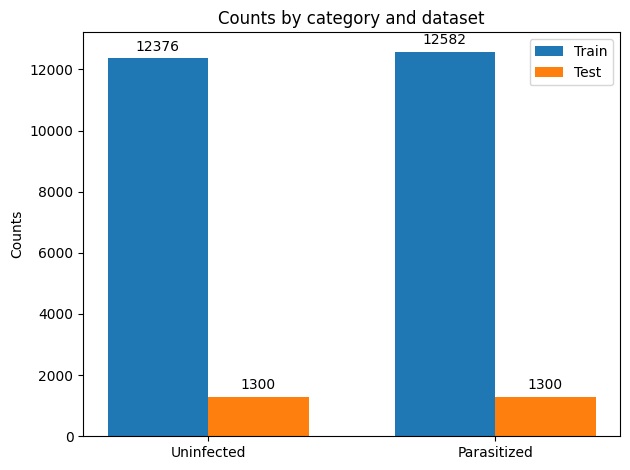

In [30]:
# Count the occurrences of each label in the training and testing datasets
unique, counts_train = np.unique(train_labels_np, return_counts=True)
train_label_counts = dict(zip(unique, counts_train))

unique, counts_test = np.unique(test_labels_np, return_counts=True)
test_label_counts = dict(zip(unique, counts_test))

# Labels for the categories
# Assuming 0 is 'Uninfected' and 1 is 'Parasitized'
labels = ["Uninfected", "Parasitized"]

# Counts for each category
train_counts = [train_label_counts.get(i, 0) for i in range(len(labels))]
test_counts = [test_label_counts.get(i, 0) for i in range(len(labels))]

# Plotting
x = range(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, train_counts, width, label="Train")
rects2 = ax.bar([p + width for p in x], test_counts, width, label="Test")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Counts")
ax.set_title("Counts by category and dataset")
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()


# Function to attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

####<b> Observations and insights: **\_**


### <b>Data Exploration</b>

Let's visualize the images from the train data


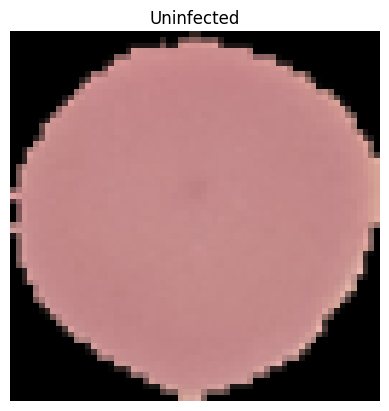

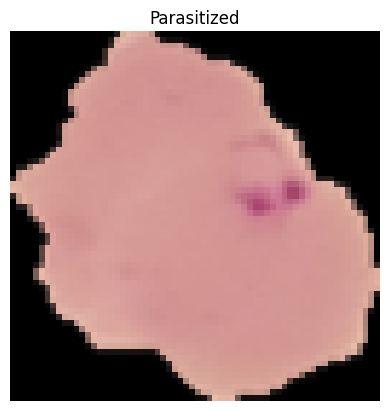

In [34]:
def visualize_random_image_by_category(images, labels, category):
    """
    Visualize a random image from a specified category with a title indicating the category.

    Parameters:
    - images: NumPy array of images.
    - labels: NumPy array of labels corresponding to the images.
    - category: The category (label) of the image to visualize.
    """
    # Find the indices of all images that belong to the specified category
    category_indices = np.where(labels == category)[0]

    # Randomly select one index from these indices
    random_index = np.random.choice(category_indices)

    # Select the image corresponding to the randomly selected index
    image = images[random_index]

    # Plot the image
    plt.imshow(image)
    plt.axis("off")  # Hide the axis

    # Set the title based on the label of the image
    if labels[random_index] == 1:
        plt.title("Parasitized")
    else:
        plt.title("Uninfected")

    plt.show()


# Assuming 0 is 'Uninfected' and 1 is 'Parasitized'
categories = [0, 1]

for category in categories:
    visualize_random_image_by_category(train_images_np, train_labels_np, category)

####<b> Observations and insights: **\_**


###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)


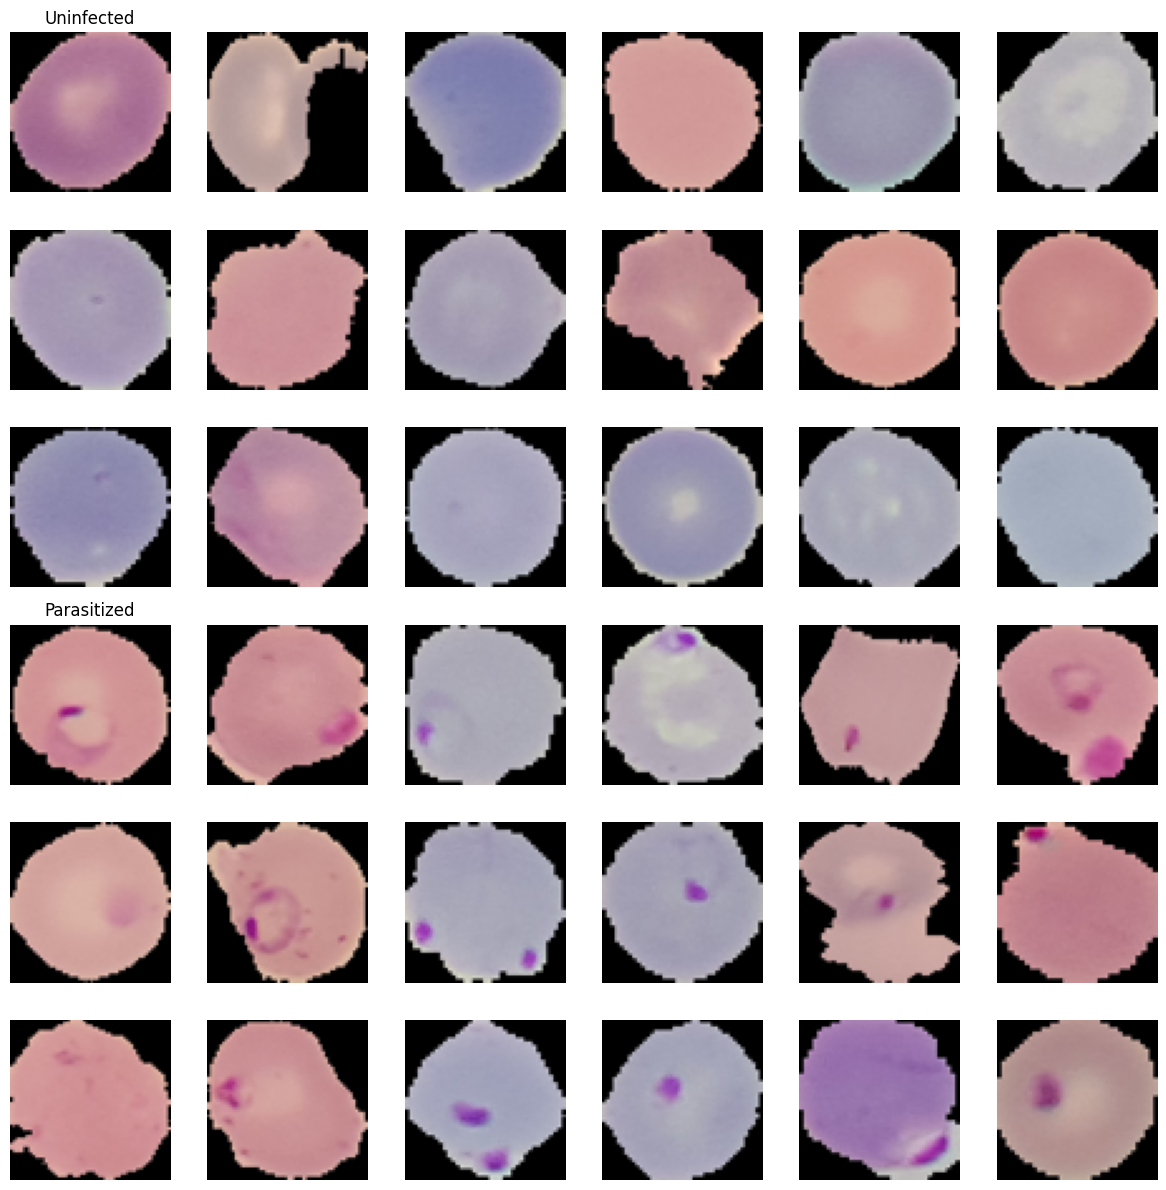

In [36]:
def visualize_random_images_grid(images, labels, figsize=(12, 12), grid_size=(6, 6)):
    """
    Visualize random images in a grid, with separate rows for each category.

    Parameters:
    - images: NumPy array of images.
    - labels: NumPy array of labels corresponding to the images.
    - figsize: Tuple indicating the figure size.
    - grid_size: Tuple indicating the grid size (rows, columns).
    """
    plt.figure(figsize=figsize)

    # Calculate total number of images to display
    total_images = grid_size[0] * grid_size[1]

    # Assuming there are two categories: 0 for 'Uninfected' and 1 for 'Parasitized'
    categories = np.unique(labels)
    num_categories = len(categories)
    images_per_category = total_images // num_categories

    for category in categories:
        category_indices = np.where(labels == category)[0]
        random_indices = np.random.choice(category_indices, images_per_category, replace=False)

        for i, index in enumerate(random_indices):
            # Calculate the position in the grid
            position = category * images_per_category + i + 1
            plt.subplot(grid_size[0], grid_size[1], position)
            plt.imshow(images[index])
            plt.axis("off")

            # Add title only to the first image of each category
            if i == 0:
                title = "Parasitized" if category == 1 else "Uninfected"
                plt.title(title)

    plt.tight_layout()
    plt.show()


# Visualize the images
visualize_random_images_grid(train_images_np, train_labels_np)

####<b>Observations and insights:


###<b> Plotting the mean images for parasitized and uninfected


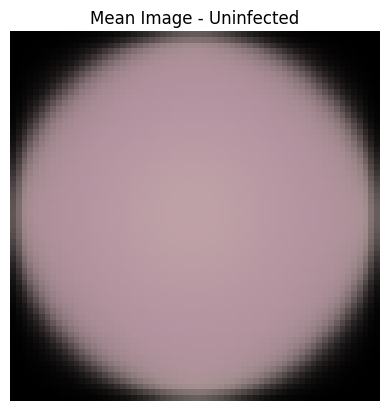

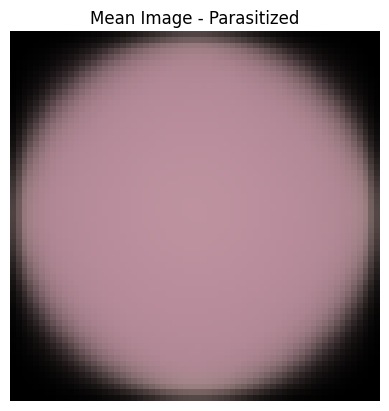

In [37]:
def plot_mean_image(images, labels, category):
    """
    Plot the mean image for a specified category.

    Parameters:
    - images: NumPy array of images.
    - labels: NumPy array of labels corresponding to the images.
    - category: The category (label) for which to plot the mean image.
    """
    # Find indices of all images that belong to the specified category
    category_indices = np.where(labels == category)[0]

    # Select all images belonging to the specified category
    category_images = images[category_indices]

    # Calculate the mean image
    mean_image = np.mean(category_images, axis=0)

    # Plot the mean image
    plt.imshow(mean_image.astype(np.uint8))
    plt.axis("off")  # Hide the axis

    title = "Parasitized" if category == 1 else "Uninfected"
    plt.title(f"Mean Image - {title}")
    plt.show()


# Assuming 0 is 'Uninfected' and 1 is 'Parasitized'
categories = [0, 1]

for category in categories:
    plot_mean_image(train_images_np, train_labels_np, category)

<b> Mean image for parasitized


<b> Mean image for uninfected


####<b> Observations and insights: **\_**


### <b>Converting RGB to HSV of Images using OpenCV


In [39]:
def convert_rgb_to_hsv_and_visualize(rgb_images):
    """
    Convert an array of RGB images to HSV and visualize a sample.

    Parameters:
    - rgb_images: NumPy array of RGB images.
    """
    # Convert all RGB images to HSV
    hsv_images = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2HSV) for image in rgb_images])

    # Randomly select an image to visualize
    random_index = np.random.randint(0, len(hsv_images))
    sample_image_rgb = rgb_images[random_index]
    sample_image_hsv = hsv_images[random_index]

    # Plot the RGB and HSV images for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(cv2.cvtColor(sample_image_rgb, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
    ax[0].set_title("Original RGB Image")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(sample_image_hsv, cv2.COLOR_HSV2RGB))  # Convert HSV back to RGB for plotting
    ax[1].set_title("Converted HSV Image")
    ax[1].axis("off")

    plt.show()

    return hsv_images

###<b> Converting the train data


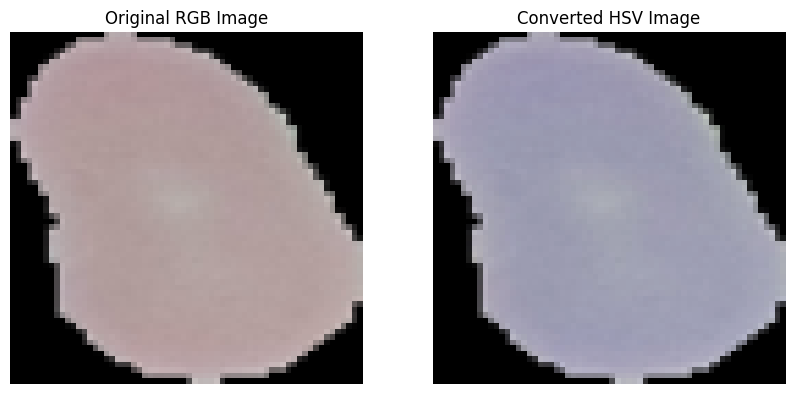

In [40]:
train_images_hsv = convert_rgb_to_hsv_and_visualize(train_images_np)

###<b> Converting the test data


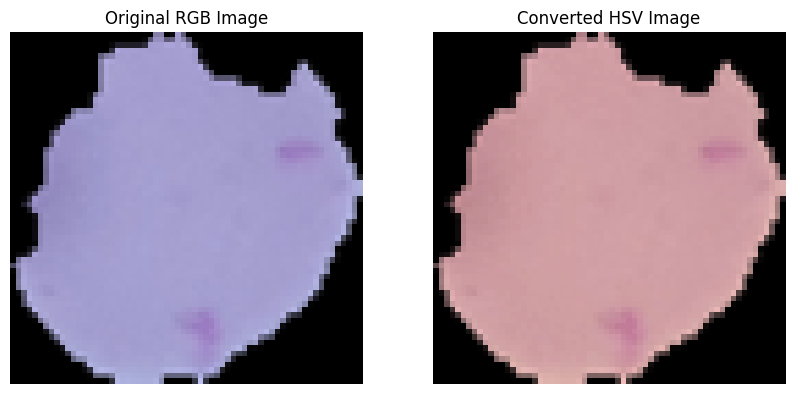

In [41]:
test_images_hsv = convert_rgb_to_hsv_and_visualize(test_images_np)

####<b>Observations and insights: **\_**


###<b> Processing Images using Gaussian Blurring


In [42]:
def apply_gaussian_blur_and_visualize(images):
    """
    Apply Gaussian blurring to an array of images and visualize a sample.

    Parameters:
    - images: NumPy array of images.
    """
    # Apply Gaussian Blurring to all images
    blurred_images = np.array([cv2.GaussianBlur(image, (5, 5), 0) for image in images])

    # Randomly select an image to visualize
    random_index = np.random.randint(0, len(images))
    original_image = images[random_index]
    blurred_image = blurred_images[random_index]

    # Plot the original and blurred images for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Gaussian Blurred Image")
    ax[1].axis("off")

    plt.show()

    return blurred_images

###<b> Gaussian Blurring on train data


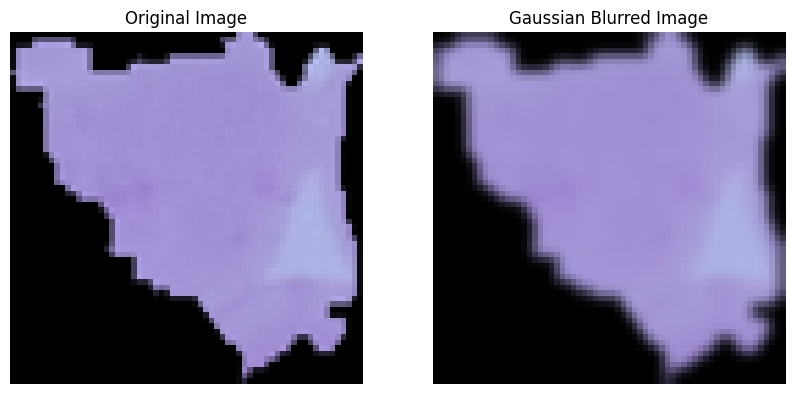

In [43]:
train_images_blurred = apply_gaussian_blur_and_visualize(train_images_np)

###<b> Gaussian Blurring on test data


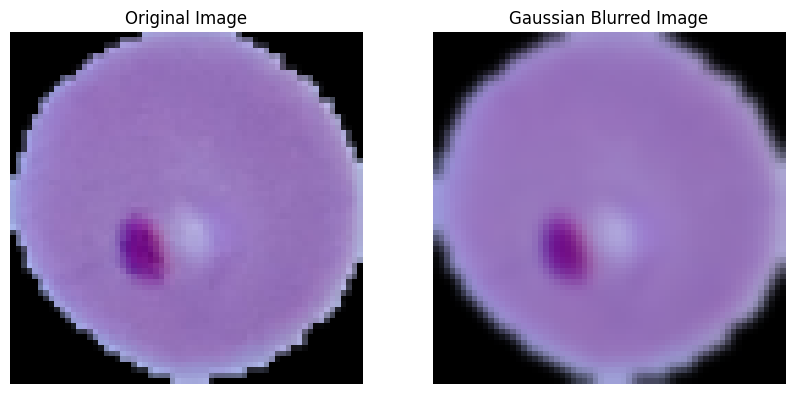

In [44]:
# Apply Gaussian blurring and visualize a sample from the testing dataset
test_images_blurred = apply_gaussian_blur_and_visualize(test_images_np)

####**Observations and insights: **\_\*\*\*\*

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?


## **Model Building**


### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.


###<b> Importing the required libraries for building and training our Model


In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

from random import shuffle
import random
import datetime

In [47]:
# Initialize the ImageDataGenerator for the training set with rescaling and validation split
# Adjusted ImageDataGenerator with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # Keep the validation split
    rotation_range=40,  # Degrees, 0-180
    width_shift_range=0.2,  # Fraction of total width
    height_shift_range=0.2,  # Fraction of total height
    shear_range=0.2,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    vertical_flip=True,  # Randomly flip inputs vertically
    fill_mode="nearest",  # Strategy to fill newly created pixels
)

# Dimensions of the images
width, height, channels = 64, 64, 3

# Batch size
batch_size = 32

# Binary Classification
class_mode = "binary"

# Training set generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Use the specified path for the training data
    target_size=(height, width),  # Adjust target_size based on your CNN input layer
    batch_size=batch_size,  # Adjust batch_size according to your system's capability
    class_mode=class_mode,  # 'binary' for binary classification, 'categorical' for multi-class
    subset="training",
)  # Specify this is the training subset

# Validation set generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Same directory as train, but will use the validation_split
    target_size=(height, width),  # Should match the target_size of the training set
    batch_size=batch_size,  # Matching the batch_size of the training set
    class_mode=class_mode,  # Matching the class_mode of the training set
    subset="validation",
)  # Specify this is the validation subset

# For the test set, since it's a separate directory without a need for splitting
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescaling is needed for the test set

# Test set generator
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Use the specified path for the test data
    target_size=(height, width),  # Should match the target_size of the training/validation set
    batch_size=batch_size,  # Can be adjusted, often matches the training set batch_size
    class_mode=class_mode,  # Should match the class_mode of the training set
    shuffle=False,
)  # Typically, you don't shuffle the test set to keep predictions in order

Found 19967 images belonging to 2 classes.
Found 4991 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


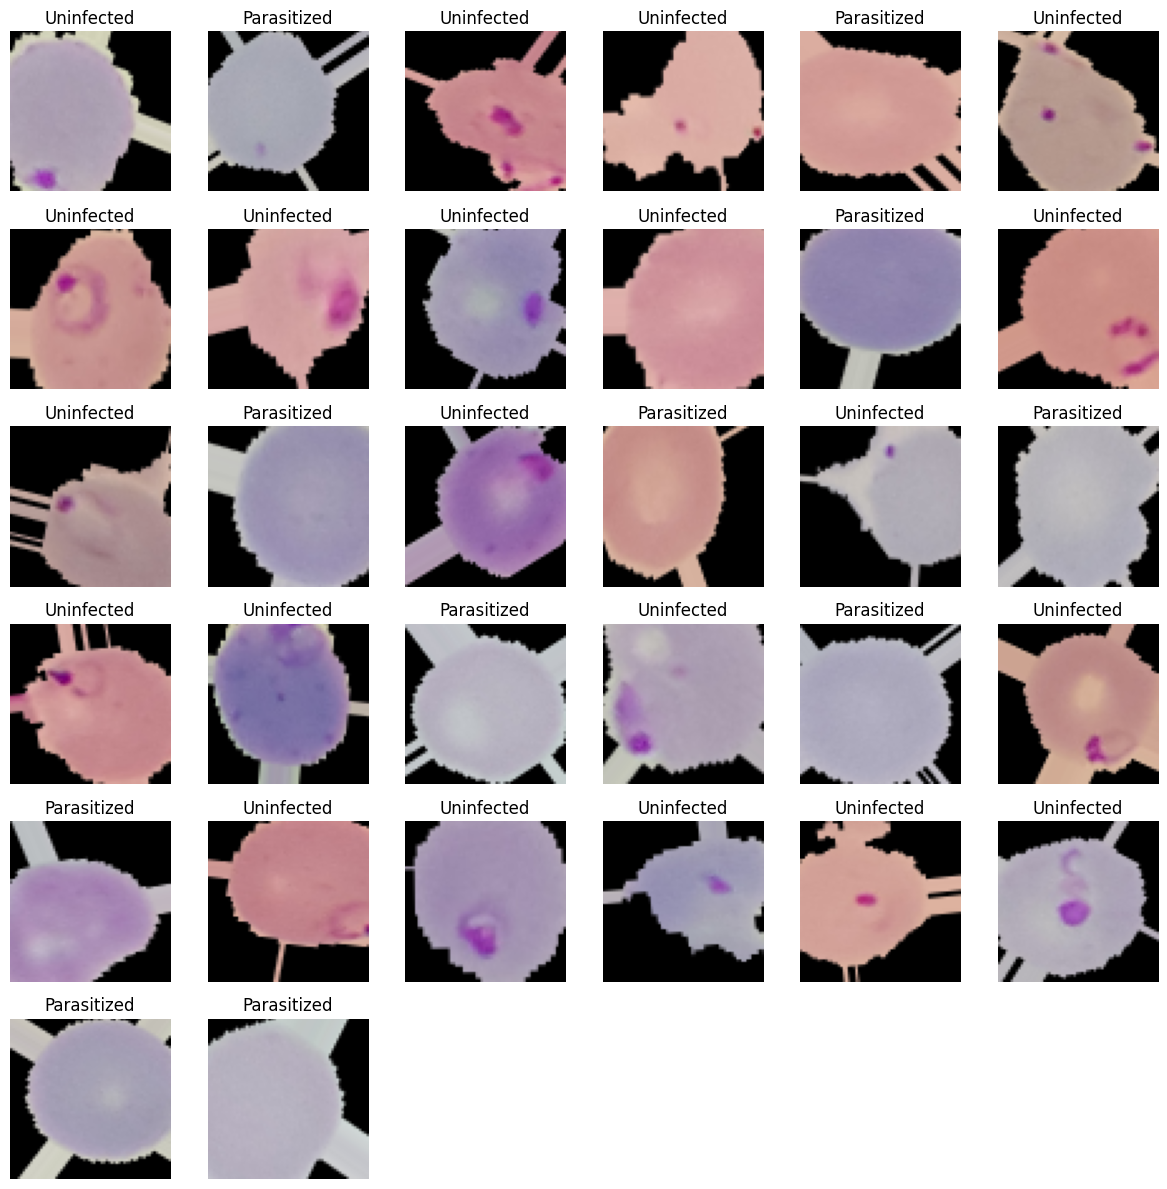

In [106]:
def visualize_augmented_images_from_generator(image_data_generator, batch_size=36):
    """
    Visualize augmented images in a 6x6 grid from the provided ImageDataGenerator.

    Parameters:
    - image_data_generator: An instance of ImageDataGenerator with augmentation and flow_from_directory already set up.
    - batch_size: The number of images to generate and visualize (default is 36 for a 6x6 grid).
    """
    # Get a batch of images
    images, labels = next(image_data_generator)

    # Set up the grid
    plt.figure(figsize=(12, 12))
    for i in range(min(batch_size, len(images))):  # Ensure we don't go over the batch size or number of images
        plt.subplot(6, 6, i + 1)
        # Check if images need rescaling
        if images[i].max() > 1.0:
            plt.imshow(images[i].astype("uint8"))
        else:
            plt.imshow(images[i])
        plt.axis("off")
        plt.title("Parasitized" if labels[i] else "Uninfected")
    plt.tight_layout()
    plt.show()


# Assuming train_generator is already defined and configured
visualize_augmented_images_from_generator(train_generator)

In [73]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)


random.seed(42)

tf.random.set_seed(42)

###<b> Building the model


In [74]:
# Creating sequential model
model_1 = Sequential()

model_1.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu", input_shape=(width, height, channels)))
model_1.add(MaxPooling2D(pool_size=2))
model_1.add(Dropout(0.2))

model_1.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
model_1.add(MaxPooling2D(pool_size=2))
model_1.add(Dropout(0.2))

model_1.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
model_1.add(MaxPooling2D(pool_size=2))
model_1.add(Dropout(0.2))

model_1.add(Flatten())
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.4))
model_1.add(Dense(1, activation="sigmoid"))  # 2 represents output layer neurons

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model


In [75]:
model_1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

<b> Using Callbacks


In [76]:
# Generate a timestamp
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define the path including the results folder, model name, and current time
checkpoint_path = f"../results/model_1_{current_time}.hdf5"

In [77]:
# Update the callbacks list with the new ModelCheckpoint path
callbacks = [
    EarlyStopping(monitor="val_loss", patience=2),
    ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=3, min_lr=0.001),
]

<b> Fit and train our Model


In [78]:
history_1 = model_1.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/20


2024-03-29 11:17:12.096755: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


624/624 [==============================] - 26s 41ms/step - loss: 0.4587 - accuracy: 0.7748 - val_loss: 0.1923 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 2/20
  3/624 [..............................] - ETA: 19s - loss: 0.1551 - accuracy: 0.9583

/home/iamtxena/sandbox/mit-ai/my_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


624/624 [==============================] - 26s 41ms/step - loss: 0.2059 - accuracy: 0.9263 - val_loss: 0.1871 - val_accuracy: 0.9335 - lr: 0.0010
Epoch 3/20
624/624 [==============================] - 26s 41ms/step - loss: 0.1753 - accuracy: 0.9416 - val_loss: 0.1866 - val_accuracy: 0.9287 - lr: 0.0010
Epoch 4/20
624/624 [==============================] - 25s 41ms/step - loss: 0.1604 - accuracy: 0.9476 - val_loss: 0.1499 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 5/20
624/624 [==============================] - 25s 41ms/step - loss: 0.1557 - accuracy: 0.9493 - val_loss: 0.1340 - val_accuracy: 0.9535 - lr: 0.0010
Epoch 6/20
624/624 [==============================] - 25s 41ms/step - loss: 0.1535 - accuracy: 0.9494 - val_loss: 0.1237 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 7/20
624/624 [==============================] - 25s 41ms/step - loss: 0.1485 - accuracy: 0.9508 - val_loss: 0.1326 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 8/20
624/624 [==============================] - 26s 41ms/step -

###<b> Evaluating the model on test data


In [79]:
accuracy = model_1.evaluate(test_generator, verbose=1)

# Print the test accuracy with two decimal places
print("\nTest Accuracy:", f"{accuracy[1]:.2f}")

82/82 [==============================] - 1s 14ms/step - loss: 0.0584 - accuracy: 0.9831

Test Accuracy: 0.98


<b> Plotting the confusion matrix


 4/82 [>.............................] - ETA: 1s

82/82 [==============================] - 1s 14ms/step
Classification Report for CNN First Model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



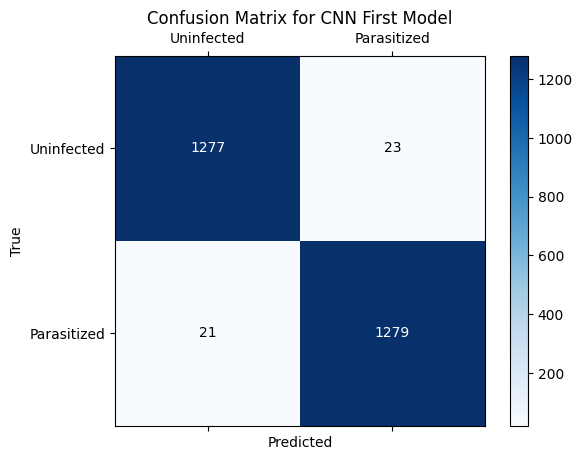

In [84]:
# Predict probabilities
predictions = model_1.predict(test_generator)

# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int).flatten()

# True labels
true_labels = test_generator.classes

# Model name variable
model_name = "CNN First Model"

# Print classification report
print(f"Classification Report for {model_name}:")
print(classification_report(true_labels, binary_predictions))

# Compute confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

plt.title(f"Confusion Matrix for {model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")

# Set the positions of the ticks and their labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["Uninfected", "Parasitized"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["Uninfected", "Parasitized"])

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

<b>Plotting the train and validation curves


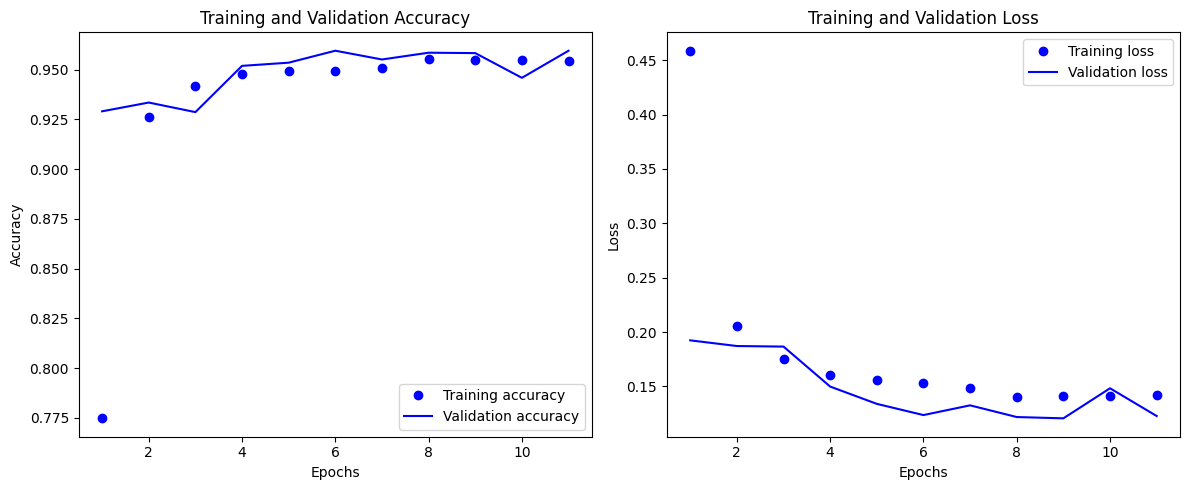

In [82]:
# Assuming 'history' is the history object returned by model.fit()
acc = history_1.history["accuracy"]
val_acc = history_1.history["val_accuracy"]
loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.


###<b> Model 1 ####<b> Trying to improve the performance of our model by adding new layers


In [85]:
backend.clear_session()  # Clearing the backend for new model

###<b> Building the Model


In [86]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU

In [87]:
# Creating a new sequential model
model_2 = Sequential()

# Input layer
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=(width, height, channels)))
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

# Adding more convolutional layers with increased filters
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.3))

model_2.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.4))

# Flatten the output of the convolutional layers to feed into the dense layers
model_2.add(Flatten())

# Dense layers
model_2.add(Dense(512))
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation="sigmoid"))  # Output layer with sigmoid activation for binary classification

# Print the model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1

###<b> Compiling the model


In [88]:
model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

<b> Using Callbacks


In [89]:
# Generate a timestamp
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define the path including the results folder, model name, and current time
checkpoint_path = f"../results/model_2_{current_time}.hdf5"

In [90]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=4),
    ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=3, min_lr=0.00001),
]

<b>Fit and Train the model


In [91]:
history_2 = model_2.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/20


2024-03-29 11:30:30.587754: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


624/624 [==============================] - 28s 42ms/step - loss: 0.8969 - accuracy: 0.6764 - val_loss: 2.5622 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 2/20
  3/624 [..............................] - ETA: 19s - loss: 0.4896 - accuracy: 0.8125

/home/iamtxena/sandbox/mit-ai/my_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


624/624 [==============================] - 25s 41ms/step - loss: 0.2846 - accuracy: 0.8928 - val_loss: 0.1982 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 3/20
624/624 [==============================] - 26s 42ms/step - loss: 0.1998 - accuracy: 0.9348 - val_loss: 0.1486 - val_accuracy: 0.9497 - lr: 0.0010
Epoch 4/20
624/624 [==============================] - 26s 42ms/step - loss: 0.1884 - accuracy: 0.9386 - val_loss: 0.1611 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 5/20
624/624 [==============================] - 25s 41ms/step - loss: 0.1788 - accuracy: 0.9445 - val_loss: 0.1942 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 6/20
624/624 [==============================] - 26s 41ms/step - loss: 0.1832 - accuracy: 0.9441 - val_loss: 0.1363 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 7/20
624/624 [==============================] - 25s 41ms/step - loss: 0.1766 - accuracy: 0.9470 - val_loss: 0.2210 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 8/20
624/624 [==============================] - 26s 41ms/step -

###<b> Evaluating the model


In [92]:
accuracy = model_2.evaluate(test_generator, verbose=1)

# Print the test accuracy with two decimal places
print("\nTest Accuracy:", f"{accuracy[1]:.2f}")

82/82 [==============================] - 1s 16ms/step - loss: 0.0418 - accuracy: 0.9877

Test Accuracy: 0.99


<b> Plotting the confusion matrix


82/82 [==============================] - 1s 14ms/step
Classification Report for CNN Second Model:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1300
           1       0.98      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



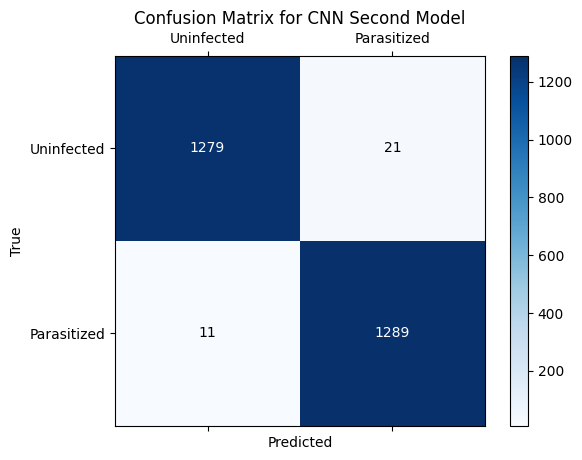

In [93]:
# Predict probabilities
predictions = model_2.predict(test_generator)

# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int).flatten()

# True labels
true_labels = test_generator.classes

# Model name variable
model_name = "CNN Second Model"

# Print classification report
print(f"Classification Report for {model_name}:")
print(classification_report(true_labels, binary_predictions))

# Compute confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

plt.title(f"Confusion Matrix for {model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")

# Set the positions of the ticks and their labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["Uninfected", "Parasitized"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["Uninfected", "Parasitized"])

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

<b> Plotting the train and the validation curves


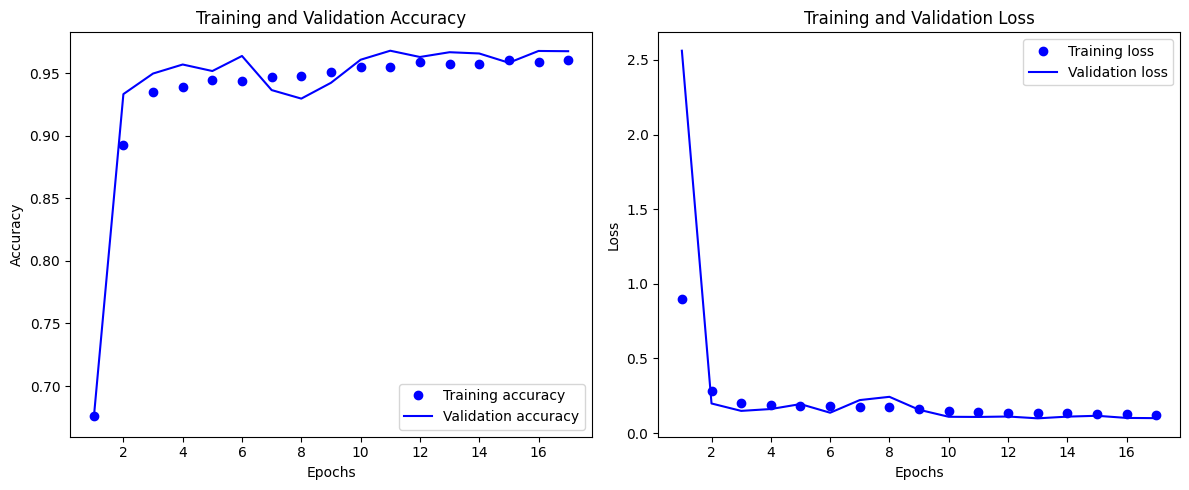

In [94]:
# Assuming 'history' is the history object returned by model.fit()
acc = history_2.history["accuracy"]
val_acc = history_2.history["val_accuracy"]
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.


### **Pre-trained model (VGG16)**

- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it


In [96]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import Input

In [95]:
# Clearing backend
import random
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)


random.seed(42)

tf.random.set_seed(42)

In [98]:
# Load the VGG16 network, ensuring the input shape matches your image data
# Include_top=False to not include the fully connected layer at the top of the network
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(width, height, channels)))

# Freeze the layers of the base_model
for layer in base_model.layers:
    layer.trainable = False

# Create the new model on top of the output of the base_model
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)  # Assuming binary classification

# Create the new model
model_vgg = Model(inputs=base_model.input, outputs=x)

# Print the model summary
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

###<b>Compiling the model


In [99]:
model_vgg.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

<b> using callbacks


In [100]:
# Generate a timestamp
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define the path including the results folder, model name, and current time
checkpoint_path = f"../results/model_vgg_{current_time}.hdf5"

<b>Fit and Train the model


In [101]:
history_vgg = model_vgg.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/20
624/624 [==============================] - 26s 41ms/step - loss: 0.3533 - accuracy: 0.8449 - val_loss: 0.3343 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 2/20
624/624 [==============================] - 25s 40ms/step - loss: 0.3007 - accuracy: 0.8755 - val_loss: 0.2991 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/20
624/624 [==============================] - 25s 41ms/step - loss: 0.2935 - accuracy: 0.8811 - val_loss: 0.3149 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 4/20
624/624 [==============================] - 25s 41ms/step - loss: 0.2837 - accuracy: 0.8840 - val_loss: 0.2833 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 5/20
624/624 [==============================] - 25s 40ms/step - loss: 0.2778 - accuracy: 0.8898 - val_loss: 0.2812 - val_accuracy: 0.8814 - lr: 0.0010
Epoch 6/20
624/624 [==============================] - 25s 40ms/step - loss: 0.2700 - accuracy: 0.8906 - val_loss: 0.2814 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 7/20
624/624 [==============================] - 25s 

<b>Plot the train and validation accuracy


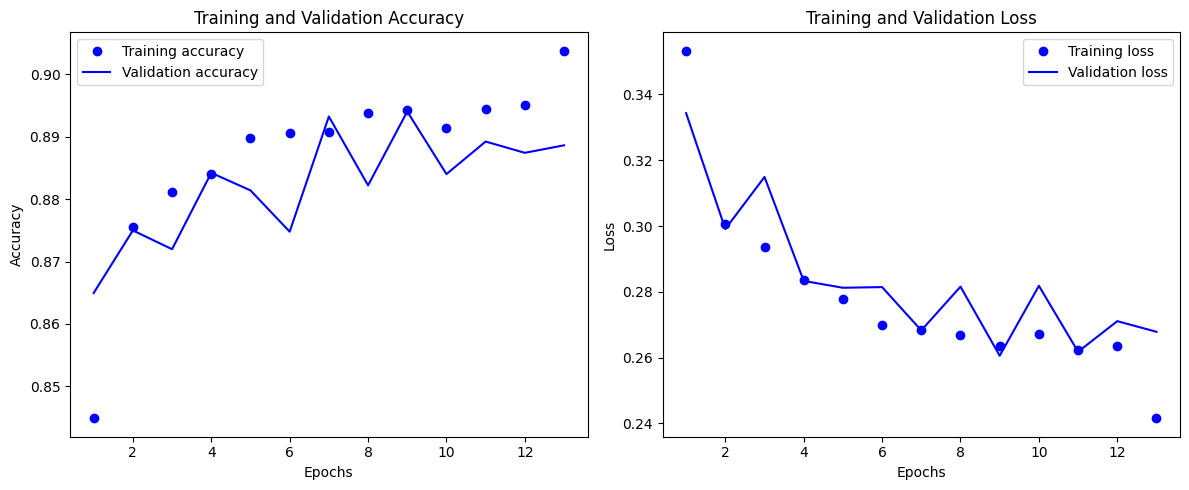

In [104]:
# Assuming 'history' is the history object returned by model.fit()
acc = history_vgg.history["accuracy"]
val_acc = history_vgg.history["val_accuracy"]
loss = history_vgg.history["loss"]
val_loss = history_vgg.history["val_loss"]

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

###**Observations and insights: **\_\*\*\*\*

- What can be observed from the validation and train curves?


###<b> Evaluating the model


In [102]:
accuracy = model_vgg.evaluate(test_generator, verbose=1)

# Print the test accuracy with two decimal places
print("\nTest Accuracy:", f"{accuracy[1]:.2f}")

82/82 [==============================] - 1s 15ms/step - loss: 0.1921 - accuracy: 0.9254

Test Accuracy: 0.93


<b>Plotting the classification report and confusion matrix


82/82 [==============================] - 1s 13ms/step
Classification Report for CNN VGG16 Model:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1300
           1       0.95      0.90      0.92      1300

    accuracy                           0.93      2600
   macro avg       0.93      0.93      0.93      2600
weighted avg       0.93      0.93      0.93      2600



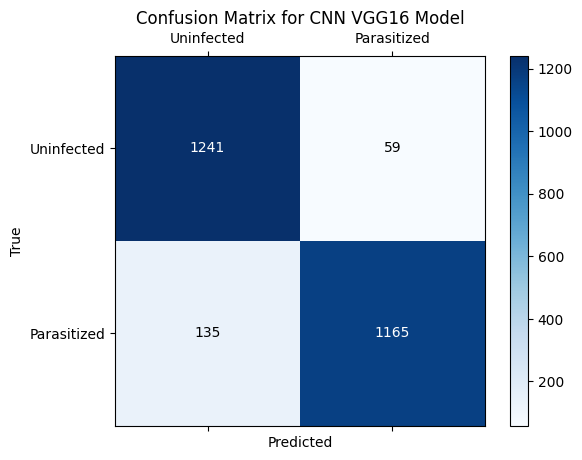

In [103]:
# Predict probabilities
predictions = model_vgg.predict(test_generator)

# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int).flatten()

# True labels
true_labels = test_generator.classes

# Model name variable
model_name = "CNN VGG16 Model"

# Print classification report
print(f"Classification Report for {model_name}:")
print(classification_report(true_labels, binary_predictions))

# Compute confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

plt.title(f"Confusion Matrix for {model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")

# Set the positions of the ticks and their labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["Uninfected", "Parasitized"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["Uninfected", "Parasitized"])

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
plt.show()